# Fruit Identification

In [36]:
# import libraries
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_files


# deep learning libraries
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

# 1.1 Organize Data: Combine The Data

First I will take all the images from the training and test set and put them into one set

In [11]:
# collect all data into one set, the "Complete_Set"
try:
    os.mkdir("Complete_Set")

# iterate over train and test sets
for set_folder in ["Training", "Test"]:
    
    # iterate over all the different folders for fruit in both training and test sets
    for fruit_folder in os.listdir(set_folder):
        
        # create a new folder in the complete set everytime a new fruit is seen
        if fruit_folder not in os.listdir("Complete_Set"):
            os.mkdir("Complete_Set\\" + fruit_folder)
        
        # iterate over every image 
        for img in os.listdir(set_folder + "\\" + fruit_folder):
        
            # save the names of the old and new file paths
            origin = set_folder + "\\" + fruit_folder + "\\" + img
            destination = "Complete_Set\\" + fruit_folder + "\\" + img
            
            # copy the files into the complete set folder
            shutil.copyfile(origin, destination)

# 1.2 Organize Data: Find Class Distribution
Here I will tally up how many pictures belong to each class of fruit.

In [9]:
# create a storage space for the information
fruit_count = []

# loop through all the different fruit folders
for fruit_folder in os.listdir("Complete_Set"):
    
    # count the amount of images
    n_imgs = len([img for img in os.listdir("Complete_Set\\" + fruit_folder)])
    
    # add data to storage space
    fruit_count.append({"fruit name":fruit_folder, "n_imgs":n_imgs})
    
# save data to dataframe
count_df = pd.DataFrame(fruit_count)

count_df.head()

,fruit name,n_imgs
0,Apple Braeburn,656
1,Apple Crimson Snow,592
2,Apple Golden 1,640
3,Apple Golden 2,656
4,Apple Golden 3,642


There are 131 different types of fruit in this data set. With 90375 images total.

The median amount of images per a fruit is 656.0.

The least represented fruit is Ginger Root. It has a total of 396 Images.




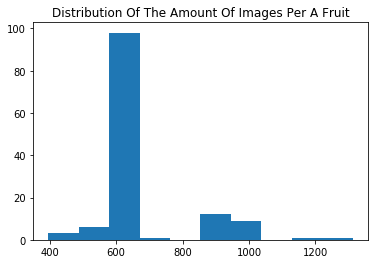

In [22]:
# print how many total fruit their are total and how many images their are total
print(f"There are {len(count_df)} different types of fruit in this data set. With {sum(count_df.n_imgs)} images total.\n")

# print the median amount of images per a fruit
print(f"The median amount of images per a fruit is {count_df.n_imgs.median()}.\n")

# print the fruit with the minimum photos and print what that minimum value is
rare_fruit = count_df[count_df.n_imgs == count_df.n_imgs.min()]["fruit name"].values[0]
print(f"The least represented fruit is {rare_fruit}. It has a total of {count_df.n_imgs.min()} Images.\n\n")

# plot distribution of fruit counts
plt.hist(count_df.n_imgs)
plt.title("distribution of the amount of images per a fruit".title())
plt.show()

# 1.3 Organize Data: Train/Validation/Test Split
Now I will do a 70/15/15 split into train, validation, and test sets for each unique fruit

In [49]:
# create a helper function for counting images in a fruit folder
def img_count(fruit_folder):
    n_imgs = len(os.listdir(fruit_folder))
    return n_imgs

# create a helper function for finding the correct indexes to split on
# based on the number of images in a fruit folder
def find_indexes(n_imgs):
    import numpy as np
    
    train_index = int(np.ceil(0.7 * n_imgs))
    val_index = int(0.85 * n_imgs)
    
    return train_index, val_index

# create a function to split a fruit folder
def split_fruit(fruit_folder, train_directory, val_directory, test_directory):
    
    # find number of images in fruit folder
    n_imgs = img_count("Complete_Set\\" + fruit_folder)
    
    # find indexes to split on
    train_index, val_index = find_indexes(n_imgs)
    
    # create a list of all the images in the folder
    imgs = [img for img in os.listdir("Complete_Set\\" + fruit_folder)]
    
    # shuffle images to ensure randomness
    np.random.shuffle(imgs)
    
    # iterate over images
    for img in imgs:
        
        # save file path origin for image
        origin = "Complete_Set\\" + fruit_folder + "\\" + img
        
        # instantiate a variable for the destination file path
        destination = ""
        
        # based on the index find the correct destination
        if img in imgs[ : train_index]:
            destination = train_directory + "\\" + fruit_folder +"\\" + img
        elif img in imgs[train_index : val_index]:
            destination = val_directory + "\\" + fruit_folder +"\\" + img
        else:
            destination = test_directory + "\\" + fruit_folder +"\\" + img
            
        # copy image to the correct destination
        shutil.copyfile(origin, destination)

In [50]:
# iterate over all the unique fruits in the complete data set
for fruit_folder in os.listdir("Complete_Set"):
    
    # iterate over the three new sets: train, validation, and test
    for subset in ["new_train", "new_validation", "new_test"]:
        
        # if not done already, create a new directory for each set
        try:
            os.mkdir(subset)
        except:
            pass
        
        # if there is not one already, make a new directory for the unique fruit
        try:
            os.mkdir(subset + "\\" + fruit_folder)
        except:
            pass
    
    # copy the images over and do the train/val/test split
    split_fruit(fruit_folder, "new_train", "new_validation", "new_test")

# 1.4 Organize Data: Establish X and Y Variables

In [7]:
# taken from kaggle post 
# https://www.kaggle.com/aninditapani/cnn-from-scratch-with-98-accuracy
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
X_train, y_train, target_labels = load_dataset("new_train")
X_val, y_val, _ = load_dataset("new_validation")
X_test, y_test, _ = load_dataset("new_test")

# 2.1 Preprocessing: One Hot Encode Y Variable

In [13]:
len(np.unique(y_train))

131

In [14]:
def encode_y(y):
    return np_utils.to_categorical(y, 131)

y_train = encode_y(y_train)
y_val = encode_y(y_val)
y_test = encode_y(y_test)

In [15]:
y_train.shape

(63342, 131)

# 2.2 Preprocessing: Turn X Into A Pixel Value Array

In [16]:
X_train[0]

'new_train\\Apple Red 2\\320_100.jpg'

In [21]:
def X_to_array(X):
    arr = []
    for img in X:
        arr.append(img_to_array(load_img(img)))
    return np.array(arr)

In [22]:
X_train = X_to_array(X_train)
X_val = X_to_array(X_val)
X_test = X_to_array(X_test)

X_train.shape

(63342, 100, 100, 3)

# 2.3 Preprocessing: Scale X

In [29]:
X_train[0][0][:5]

array([[254., 255., 255.],
       [254., 255., 255.],
       [254., 255., 255.],
       [254., 255., 255.],
       [255., 255., 255.]], dtype=float32)

In [30]:
def scale(X):
    return X

X_train = scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

# 3.1 Modeling: Creating A Model Architecture

In [33]:
# inspired from kaggle post 
# https://www.kaggle.com/aninditapani/cnn-from-scratch-with-98-accuracy
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 4, input_shape=(100,100,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=4))

model.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=3))

model.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters = 128, kernel_size = 2, activation = 'relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(131, activation = 'softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 16)      784       
_________________________________________________________________
activation_2 (Activation)    (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)         

In [35]:
# taken from kaggle post 
# https://www.kaggle.com/aninditapani/cnn-from-scratch-with-98-accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


# 3.2 Modeling: Training

In [ ]:
# taken from kaggle post 
# https://www.kaggle.com/aninditapani/cnn-from-scratch-with-98-accuracy
model_checkpoint = ModelCheckpoint(filepath = 'cnn.hdf5', verbose = 1, save_best_only = True)

history = model.fit(X_train, y_train,
        batch_size = 50,
        epochs = 7,
        validation_data=(X_val, y_val),
        callbacks = [model_checkpoint],
        verbose=2, shuffle=True)

Train on 63342 samples, validate on 13409 samples
Epoch 1/7
 - 172s - loss: 0.5751 - accuracy: 0.9147 - val_loss: 0.0384 - val_accuracy: 0.9921

Epoch 00001: val_loss improved from inf to 0.03836, saving model to cnn.hdf5
Epoch 2/7
 - 167s - loss: 0.6416 - accuracy: 0.9102 - val_loss: 0.1337 - val_accuracy: 0.9776

Epoch 00002: val_loss did not improve from 0.03836
Epoch 3/7
 - 154s - loss: 0.7071 - accuracy: 0.9085 - val_loss: 0.2205 - val_accuracy: 0.9491

Epoch 00003: val_loss did not improve from 0.03836
Epoch 4/7
 - 143s - loss: 0.7139 - accuracy: 0.9042 - val_loss: 0.0433 - val_accuracy: 0.9881

Epoch 00004: val_loss did not improve from 0.03836
Epoch 5/7
 - 132s - loss: 0.7510 - accuracy: 0.9063 - val_loss: 0.0345 - val_accuracy: 0.9898

Epoch 00005: val_loss improved from 0.03836 to 0.03451, saving model to cnn.hdf5
Epoch 6/7
 - 133s - loss: 0.7913 - accuracy: 0.9032 - val_loss: 0.0243 - val_accuracy: 0.9940

Epoch 00006: val_loss improved from 0.03451 to 0.02433, saving model 